**Pooya Kabiri - 96521434**

Importing prerequisites.

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
import pandas as pd
import seaborn as sn
import os
import time

In [8]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

In [9]:
from sklearn.metrics import accuracy_score,confusion_matrix
def evaluation(y_test, y_pred, fig_name, title):
    '''
    Prints accuracy and plots confusion matrix and saves result image.

    Parameters:
        y_test (numpy.ndarray) : test labels (ground truth)
        y_pred (numpy.ndarray) : predicted labels 
        fig_name (str): The name of the image of the plot.
        title (str): The caption of the plot.
    '''

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print('Accuracy for', title, '=', acc * 100)
    df_cm = pd.DataFrame(cm, range(10), range(10))
    plt.figure(figsize = (10, 7))
    sn.set(font_scale = 1.4) # for label size
    sn.heatmap(df_cm , annot = True, annot_kws = {"size" : 16}, fmt = 'g') # font size
    plt.title(title)
    plt.savefig(fig_name + '.png')
    plt.show()

# Classification using Support Vector Machines (SVM)

## Utility Functions:

**`extract_shape_desc_vec(image)`:** gets an image as input, creates a feature vector for the image and returns the vector. Uses `OpenCV` contours for extracting features **(Compactness, Solidity, Aspect Ratio, Extreme Points, Eccentricity)**

**`get_dataset_shape_descs(dataset)`:** Gets a dataset as input, iterates over examples and transforms the image dataset to a feature vector dataset by calling `extract_shape_desc_vec(image)` for every image example. Returns the transformed dataset.

**`lbp_dataset(dataset, skimage)`:** Gets a dataset as input, iterates over examples and transforms the image dataset to a LBP Histogram vector dataset by calling `LBP(image)` for every image example. The `skimage` boolean flag determines whether to use self implemented version of LBP or the `skimage.feature` version. Returns the transformed dataset.

**`get_dataset_hogs(dataset)`:** Gets a dataset as input, iterates over examples and transforms the image dataset to a HOG vector dataset by calling `hog` method from `skimage.feature` for every image example. Returns the transformed dataset.



In [10]:
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from sklearn.metrics.pairwise import euclidean_distances

np.seterr(divide='ignore', invalid='ignore')

def extract_shape_desc_vec(image):
    
    features = []
    
    ret, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, 1, 2)
    cnt = contours[0]
    
    for c in contours:
        area = cv2.contourArea(c)
        if area > cv2.contourArea(cnt):
            cnt = c
    
    area = cv2.contourArea(cnt)
    primeter = cv2.arcLength(cnt, True)
    p2 = np.square(primeter)
    
    if not np.isfinite(p2):
        compactness = 0
    else:
        compactness = np.divide((4 * np.pi * area), (np.square(primeter)))
    
    features.append(np.nan_to_num(compactness))
    
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    if hull_area <= 0:
        solidity = 0
    else:
        solidity = float(area)/hull_area
    features.append(solidity)

    x,y,w,h = cv2.boundingRect(cnt)
    aspect_ratio = float(w)/h
    if not np.isfinite(aspect_ratio):
        aspect_ratio = 0
    features.append(aspect_ratio)
    
    leftmost = cnt[cnt[:,:,0].argmin()][0].reshape((1, -1))
    rightmost = cnt[cnt[:,:,0].argmax()][0].reshape((1, -1))
    topmost = cnt[cnt[:,:,1].argmin()][0].reshape((1, -1))
    bottommost = cnt[cnt[:,:,1].argmax()][0].reshape((1, -1))
    
    features.append(leftmost[0, 0])
    features.append(leftmost[0, 1])
    
        
    features.append(rightmost[0, 0])
    features.append(rightmost[0, 1])
    
        
    features.append(topmost[0, 0])
    features.append(topmost[0, 1])
    
        
    features.append(bottommost[0, 0])
    features.append(bottommost[0, 1])
        
    h_axis = euclidean_distances(leftmost, rightmost)
    v_axis = euclidean_distances(topmost, bottommost)
    
    eccentricity = np.sqrt(1 - np.power( np.divide(min(h_axis, v_axis), max(h_axis, v_axis)) ,2) )
    features.append(np.nan_to_num(eccentricity))
    
    return features
    
def get_dataset_shape_descs(dataset):
    
    out = []
    
    for i in range(dataset.shape[0]):
        slice = dataset[i, :, :]
        vec = extract_shape_desc_vec(slice)
        out.append(vec)
    
    final_vecs = np.array(out, dtype=np.float64)
    
    return final_vecs
    
def lbp_dataset(dataset, skimage):
    result = []
    
    for i in range(dataset.shape[0]):
        if skimage:
            hist, _ = np.histogram(local_binary_pattern(dataset[i, :, :], 8, 1, 'default'), bins=256, density=True)
            result.append(hist)
        else:
            result.append(LBP(dataset[i, :, :]))
            
        if i%10000 == 0 and (not skimage):
            print("Sample No: ", i)
    return np.array(result)

def get_dataset_hogs(dataset):
    out = []
    
    for i in range(dataset.shape[0]):
        slice = dataset[i, :, :]
        vec = hog(slice, orientations=8, pixels_per_cell=(3, 3), cells_per_block=(8, 8), visualize=False, feature_vector=True, multichannel=False)
        out.append(vec)
    
    final_vecs = np.array(out, dtype=np.float64)
    
    return final_vecs            

## Classification with HOG
**`classify_hog(x_train, y_train, x_test)`:** Classifies an image dataset using **Histogram of Gradients (HOG)** and `Linear Support Vector Classifier` from `sklearn.svm`. Returns the predicted labels for the provided test set.

In [24]:
def classify_hog(x_train, y_train, x_test):
    '''
    Classifies images with HOG.
    
    Parameters:
        x_train(numpy.ndarray) : train data
        y_train(numpy.ndarray) : train labels
        x_test(numpy.ndarray) : test data
        
    outputs:
        predicted_labels(numpy.ndarray): labels that predicted
    '''
    
    x_train_vecs = get_dataset_hogs(x_train)
        
    x_test_vecs = get_dataset_hogs(x_test)
    
    classifier = LinearSVC(multi_class='ovr', max_iter=1000)
    classifier.fit(x_train_vecs, y_train)
    
    prediction = classifier.predict(x_test_vecs)

    return prediction


## Classification with Shape Descriptors
**`classify_shape_desc(x_train, y_train, x_test)`:** Classifies an image dataset using shape descriptors: **Compactness, Solidity, Aspect Ratio, Extreme Points, Eccentricity** and `Linear Support Vector Classifier` from `sklearn.svm`. Uses `get_dataset_shape_descs` method for getting dataset descriptors. Returns the predicted labels for the provided test set.

In [6]:
def classify_shape_desc(x_train, y_train, x_test):
    '''
    Classifies images by using shape descriptors.
    
    Parameters:
        x_train(numpy.ndarray) : train data
        y_train(numpy.ndarray) : train labels
        x_test(numpy.ndarray) : test data
        
    outputs:
        predicted_labels(numpy.ndarray): labels that predicted
    '''
    
    x_train_vecs = get_dataset_shape_descs(x_train)
    x_test_vecs = get_dataset_shape_descs(x_test)
    
    classifier = LinearSVC(max_iter=1000)
    classifier.fit(x_train_vecs, y_train)
    
    prediction = classifier.predict(x_test_vecs)

    return prediction    

## Classification with Local Binary Patterns (LBP)
We are going to use two approaches: Self Implemented LBP and `skimage.feature LBP`
### Implementing Manual Local Binary Pattern
**`LBP(img)`:** Gets image as input, calculates the LBP (rotation variant) for this image. Returns histogram of LBP for the image.

In [7]:
def LBP(img):
    '''
    Extracts LBP features from the input image.
    
    Parameters:
        img(numpy.ndarray) : image data
    outputs:
        output: LBP features
    '''
    LBP_coded = np.zeros_like(img)
    
    window = 3
    
    for i in range(img.shape[0] - window):
        for j in range(img.shape[1] - window):
            
            win = img[i : i + window, j : j + window]

            win_center = win[1, 1]
            win_coded = (win >= win_center) * 1
            
            ### Flattening array and removing the center
            win_binary = np.delete(win_coded.T.flatten(), 4)
            
            ### Getting coressponding indices of 1 values within the array
            indices = np.where(win_binary)[0]
            if indices.any():
                lbp_val = np.sum(np.power(2, indices))
            else:
                lbp_val = 0
            
            LBP_coded[i + 1, j + 1] = lbp_val
        
    histogram, _ = np.histogram(LBP_coded, bins=256, density=True)
    return histogram

### Classification with Manual LBP
**`classify_your_lbp(x_train, y_train, x_test)`:** Classifies an image dataset using LBP (implemented from scratch) and `Linear Support Vector Classifier` from `sklearn.svm`. Uses `lbp_dataset` method for getting dataset LBP. Returns the predicted labels for the provided test set.

In [8]:
def classify_your_lbp(x_train, y_train, x_test):
    '''
    Classifies images by using your LBP.
    
    Parameters:
        x_train(numpy.ndarray) : train data
        y_train(numpy.ndarray) : train labels
        x_test(numpy.ndarray) : test data
        
    outputs:
        predicted_labels(numpy.ndarray): labels that predicted
    '''
    
    x_train_vecs = lbp_dataset(x_train, False)
    x_test_vecs = lbp_dataset(x_test, False)
    
    classifier = LinearSVC(max_iter=1000)
    classifier.fit(x_train_vecs, y_train)
    
    prediction = classifier.predict(x_test_vecs)    
    
    return prediction    

### Classification with Skimage LBP
**`classify_skimage_lbp(x_train, y_train, x_test)`:** Classifies an image dataset using LBP (Skimage version) and `Linear Support Vector Classifier` from `sklearn.svm`. Uses `lbp_dataset` method for getting dataset LBP. Returns the predicted labels for the provided test set.

In [17]:
def classify_skimage_lbp(x_train, y_train, x_test):
    '''
    Classifies images by using Scikit-Image LBP.
    
    Parameters:
        x_train(numpy.ndarray) : train data
        y_train(numpy.ndarray) : train labels
        x_test(numpy.ndarray) : test data
        
    outputs:
        predicted_labels(numpy.ndarray): labels that predicted
    '''
    
    x_train_vecs = lbp_dataset(x_train, True)
    x_test_vecs = lbp_dataset(x_test, True)
        
    classifier = LinearSVC(max_iter=2000)
    classifier.fit(x_train_vecs, y_train)
    
    prediction = classifier.predict(x_test_vecs)      
    
    return prediction    

## Training and Evaluation

In [22]:
data = np.load('mnist.npz')
[x_train, y_train, x_test, y_test] = data['x_train'], data['y_train'], data['x_test'], data['y_test']

Accuracy for using HOG = 97.46000000000001


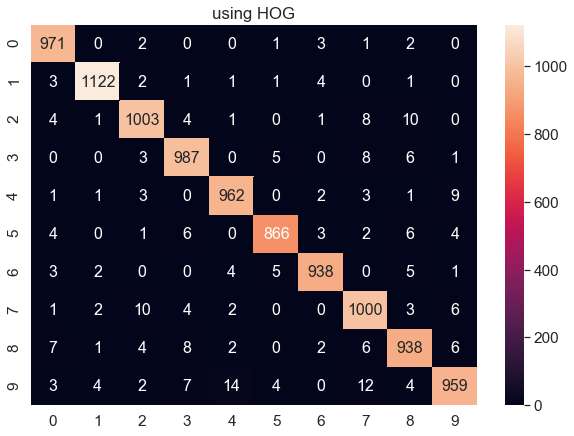

In [23]:
y_pred = classify_hog(x_train, y_train, x_test)
evaluation(y_test, y_pred, '3a', 'using HOG')

/Users/pooya/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy for using shape desacriptots = 68.21000000000001


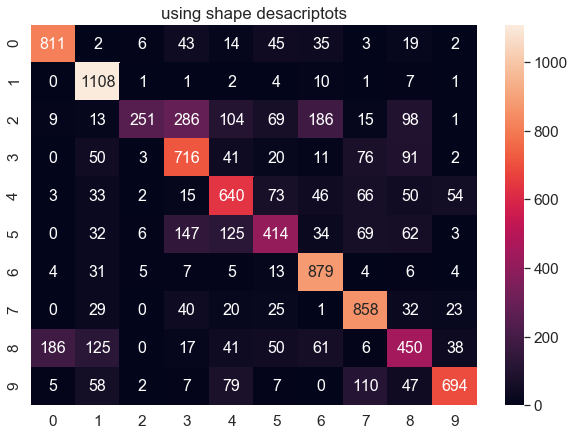

In [16]:
y_pred = classify_shape_desc(x_train, y_train, x_test)
evaluation(y_test, y_pred, '3b', 'using shape desacriptots')

Sample No:  0
Sample No:  10000
Sample No:  20000
Sample No:  30000
Sample No:  40000
Sample No:  50000
Sample No:  0
time for your LBP: 1305.269340 s
Accuracy for using your LBP = 64.75999999999999


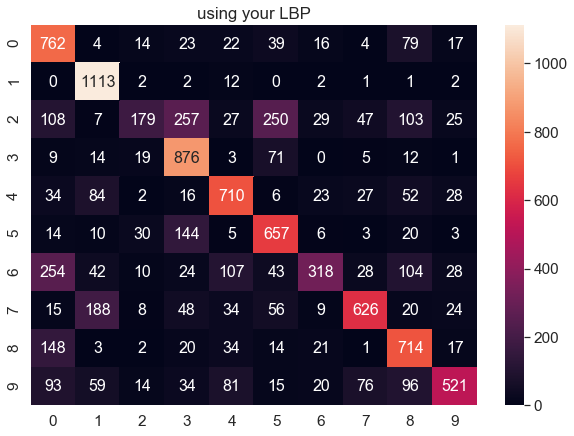

In [12]:
t1 = time.time()
y_pred = classify_your_lbp(x_train, y_train, x_test)
t2 = time.time()
print('time for your LBP: %f s' % (t2 - t1))
evaluation(y_test, y_pred, '3c', 'using your LBP')

time for Scikit-Image LBP: 33.890427 s
Accuracy for using Scikit-Image LBP = 56.42


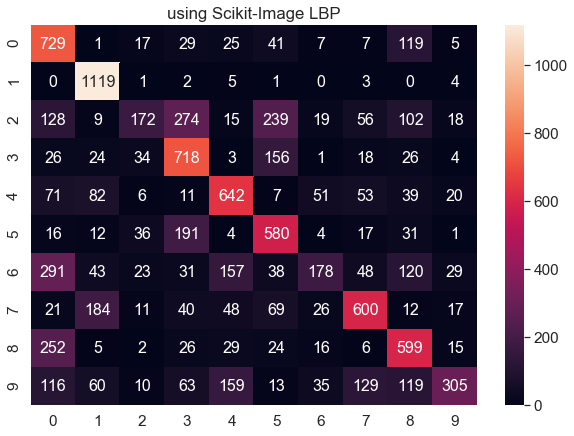

In [18]:
t1 = time.time()
y_pred = classify_skimage_lbp(x_train, y_train, x_test)
t2 = time.time()
print('time for Scikit-Image LBP: %f s' % (t2 - t1))
evaluation(y_test, y_pred, '3d', 'using Scikit-Image LBP')

**As seen,** Self implemented LBP has a very longer runtime for calculation (almost 40x) comparing to `skimage.feature lbp` method. But in terms of accuracy, the self implemented version provides more promising results (about 10% better performance).

# Leaf Classification

For classifying the leaf images, we use `Eccentricity` as a shape detector. Because if we look at linden and apple leaf shapes, there is a siginificant difference in their eccentricity. Linden leaves are more rounded and thus have a lower eccentricity, in contrast to Apple leaves which are more stretched and have a higher eccentricity.

**`calculate_eccentricity(image)`:** Gets an input image. Finds the biggest contour of the image using `finContours` method from `OpenCV`. Computes the 4 extreme-points of the contour, Then uses these 4 points to calculate the length of the minor and major axis of the contour. Then using these two lengths calculates the **Eccentricity** of the contours.

In [11]:
def calculate_eccentricity(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(thresh, 1, 2)
    
    cnt = contours[0]
    
    ### Finding the biggest contour
    for c in contours:
        area = cv2.contourArea(c)
        if area > cv2.contourArea(cnt):
            cnt = c
    
    leftmost = cnt[cnt[:,:,0].argmin()][0].reshape((1, -1))
    rightmost = cnt[cnt[:,:,0].argmax()][0].reshape((1, -1))
    topmost = cnt[cnt[:,:,1].argmin()][0].reshape((1, -1))
    bottommost = cnt[cnt[:,:,1].argmax()][0].reshape((1, -1))
        
    h_axis = euclidean_distances(leftmost, rightmost)
    v_axis = euclidean_distances(topmost, bottommost)
    
    major_axis = max(h_axis, v_axis)
    minor_axis = min(h_axis, v_axis)
    
    if major_axis == 0:
        eccentricity = 1
    else:
        eccentricity = np.sqrt(1 - np.power( np.divide(minor_axis, major_axis) ,2) )

    return eccentricity

Implement your code here.

In [17]:
def classify_leaf(image):
    '''
    Classifies the input image to only two classes of leaves.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        int: The class of the image. 1 == apple, 0 == linden
    '''
    eccentricity = calculate_eccentricity(image)
    
    if eccentricity < 0.7:
        leaf_type = 0
    else: 
        leaf_type = 1  
    
    return leaf_type

Test your implementation (don't change this cell).

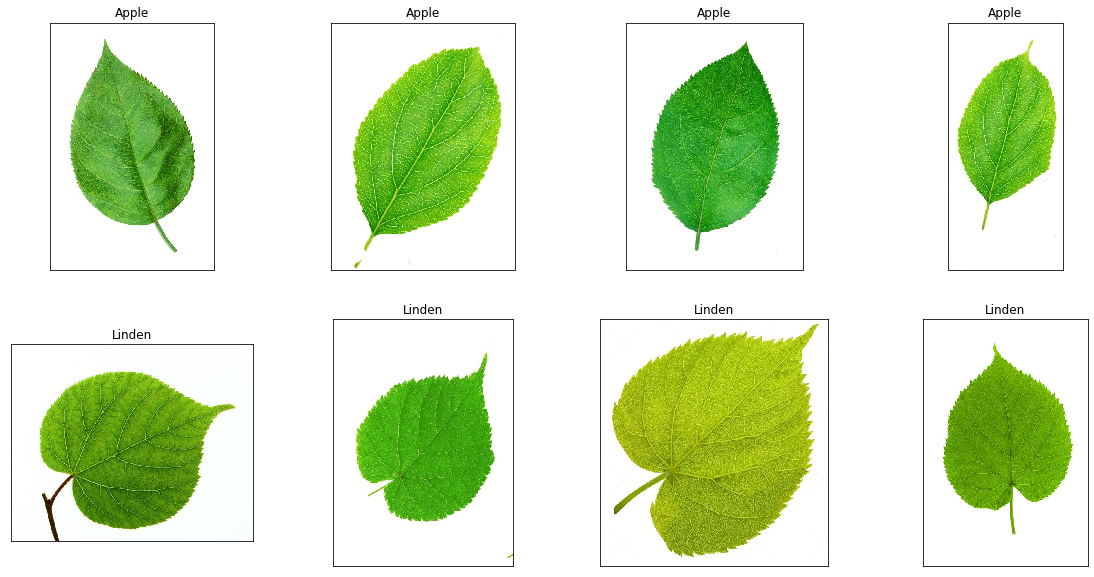

Accuracy is 0.0%


In [18]:
image_list = []
error = 0
for i in range(1,5):
    image = cv2.imread(os.path.join('images', 'apple', '{}.jpg'.format(i)))
    leaf_type = classify_leaf(image)
    error += int(leaf_type==1) 
    image_list.append([cv2.cvtColor(image, cv2.COLOR_BGR2RGB),'Apple' if leaf_type else 'Linden' , 'img'])
for i in range(1,5):
    image = cv2.imread(os.path.join('images', 'linden', '{}.jpg'.format(i)))
    leaf_type = classify_leaf(image)
    error += int(leaf_type==0) 
    image_list.append([cv2.cvtColor(image, cv2.COLOR_BGR2RGB),'Apple' if leaf_type else 'Linden' , 'img'])
plotter(image_list, 2, 4, True, 20, 10, '4')
print("Accuracy is {}%".format(100-error/0.08))